In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

import collections
import yaml
import re
import os

# Preprocessing and Keras
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input


train = pd.read_pickle('train.pkl')
train.head(10)

,Utterance,Intent
0,"[battery, phone, hot, plug, min, later, battery]",battery
1,"[forgot, my, pass]",forgot_password
2,"[payment, not, through]",payment
3,"[want, update]",update
4,"[need, information]",info
5,"[deny, service, stamford, ct, mall, store, dis...",location
6,"[talk, human, please]",speak_representative
7,[hi],greeting
8,[goodbye],goodbye
9,"[robot, human]",challenge_robot


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# For the text data
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence

X_train, X_val, y_train, y_val = train_test_split(train['Utterance'], train['Intent'], test_size = 0.3, 
                                                   shuffle = True, stratify = train['Intent'], random_state = 7)
print(f'\nShape checks:\nX_train: {X_train.shape} X_val: {X_val.shape}\ny_train: {y_train.shape} y_val: {y_val.shape}')


Shape checks:
X_train: (7000,) X_val: (3000,)
y_train: (7000,) y_val: (3000,)


In [12]:
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_val = le.transform(y_val)

In [13]:
le.classes_

array(['battery', 'challenge_robot', 'forgot_password', 'goodbye',
       'greeting', 'info', 'location', 'payment', 'speak_representative',
       'update'], dtype=object)

In [14]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
t.fit_on_texts(X_train)



In [15]:
def convert_to_padded(tokenizer, docs):

    embedded = t.texts_to_sequences(docs)
    # Padding
    padded = pad_sequences(embedded, maxlen = max_length, padding = 'post')
    return padded

In [16]:


print("Document Count: \n{}\n".format(t.document_count))


vocab_size = len(t.word_counts) + 1
print(f'Vocab size:\n{vocab_size}')


max_length = len(max(X_train, key = len))

print(f'Max length:\n{max_length}')

padded_X_train = convert_to_padded(tokenizer = t, docs = X_train)
padded_X_val = convert_to_padded(tokenizer = t, docs = X_val)

print(f'padded_X_train\n{padded_X_train}')
print(f'padded_X_val\n{padded_X_val}')

Document Count: 
7000

Vocab size:
4291
Max length:
41
padded_X_train
[[  9  15   1 ...   0   0   0]
 [ 27   6  10 ...   0   0   0]
 [ 27   6  10 ...   0   0   0]
 ...
 [ 25  31   7 ...   0   0   0]
 [  7   8  12 ...   0   0   0]
 [ 19 135 214 ...   0   0   0]]
padded_X_val
[[  11    8    0 ...    0    0    0]
 [   3    4 3161 ...    0    0    0]
 [  33    1    3 ...    0    0    0]
 ...
 [   6   10   11 ...    0    0    0]
 [ 100  155  100 ...    0    0    0]
 [  66    6   46 ...    0    0    0]]


In [17]:
padded_X_train.shape, padded_X_val.shape, y_train.shape, y_val.shape

((7000, 41), (3000, 41), (7000,), (3000,))

In [80]:
!ls models/glove.twitter.27B

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
glove_model_path = r'C:\Users\ANILHR\Downloads\glove.twitter.27B\glove.twitter.27B.100d.txt'

f = open(glove_model_path,'r')

In [19]:
embeddings_index = {}
f = open(r'C:\Users\ANILHR\Downloads\glove.twitter.27B\glove.twitter.27B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


In [20]:
word_index = t.word_index
EMBEDDING_DIM = 50 # Because we are using the 50D gloVe embeddings

# Getting my embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix, embedding_matrix.shape

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54084998,  0.96133   , -0.68097001, ..., -0.9709    ,
         -0.57907999,  0.44661999],
        [ 0.51418   , -0.19196001, -0.79962999, ..., -0.34937999,
         -1.08060002,  0.60174   ],
        ...,
        [ 0.59193999, -0.17782   ,  0.20666   , ..., -0.29806   ,
          0.14047   , -0.63893002],
        [ 0.35242   , -0.25744   , -0.20263   , ...,  0.010393  ,
         -0.59311002, -0.14812   ],
        [-0.54620999,  1.44560003,  0.29674   , ...,  0.62761003,
         -0.36403999,  0.10271   ]]),
 (4291, 50))

In [41]:
def make_model(vocab_size, max_token_length):
    ''' In this function I define all the layers of my neural network'''
    # Initialize
    model = Sequential()
    #model.add(Input(shape = (32,), dtype = 'int32'))

    # Adding layers - For embedding layer, I made sure to add my embedding matrix into the weights paramater
    model.add(Embedding(vocab_size, embedding_matrix.shape[1], input_length = 41, 
                        trainable = False, weights = [embedding_matrix]))
    
    model.add(Bidirectional(LSTM(128)))
#    model.add(LSTM(128)) 
    model.add(Dense(600, activation = "relu",kernel_regularizer ='l2')) # Try 50, another dense layer? This takes a little bit of exploration
    
    # Adding another dense layer to increase model complexity
    model.add(Dense(600, activation = "relu",kernel_regularizer ='l2'))
    
    # Only update 50 percent of the nodes - helps with overfitting
    model.add(Dropout(0.5))
    
    # This last layer should be the size of the number of your intents!
    # Use sigmoid for multilabel classification, otherwise, use softmax!
    model.add(Dense(10, activation = "softmax"))
    
    return model

# Actually creating my model with 32 as the max token length
model = make_model(vocab_size, 41)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 41, 50)            214550    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              183296    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 600)               154200    
                                                                 
 dense_7 (Dense)             (None, 600)               360600    
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                6010      
                                                      

In [42]:
filename = 'intent_classification_b.h5'

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_sched_checkpoint = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


# This saves the best model
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')


hist = model.fit(padded_X_train, y_train, epochs = 20, batch_size = 41, 
                 validation_data = (padded_X_val, y_val), 
                 callbacks = [checkpoint, lr_sched_checkpoint, early_stopping])

Epoch 1/20
171/171 [==============================] - ETA: 0s - loss: 2.6796 - accuracy: 0.6940
Epoch 1: val_loss improved from inf to 0.79141, saving model to intent_classification_b.h5
171/171 [==============================] - 23s 99ms/step - loss: 2.6796 - accuracy: 0.6940 - val_loss: 0.7914 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 2/20
171/171 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.8666
Epoch 2: val_loss improved from 0.79141 to 0.58295, saving model to intent_classification_b.h5
171/171 [==============================] - 15s 86ms/step - loss: 0.6478 - accuracy: 0.8666 - val_loss: 0.5830 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 3/20
171/171 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.8774
Epoch 3: val_loss improved from 0.58295 to 0.52720, saving model to intent_classification_b.h5
171/171 [==============================] - 19s 112ms/step - loss: 0.5356 - accuracy: 0.8774 - val_loss: 0.5272 - val_accuracy: 0.8833 - lr:

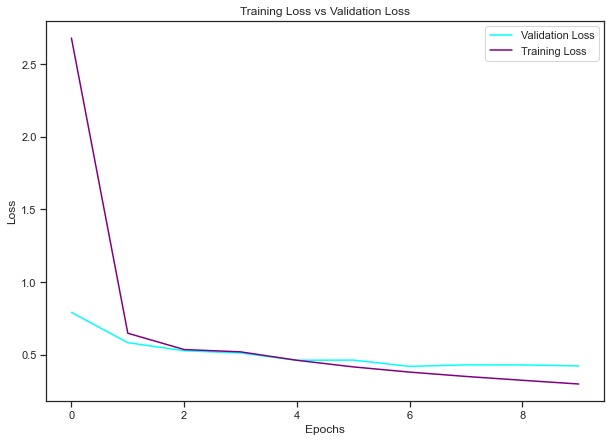

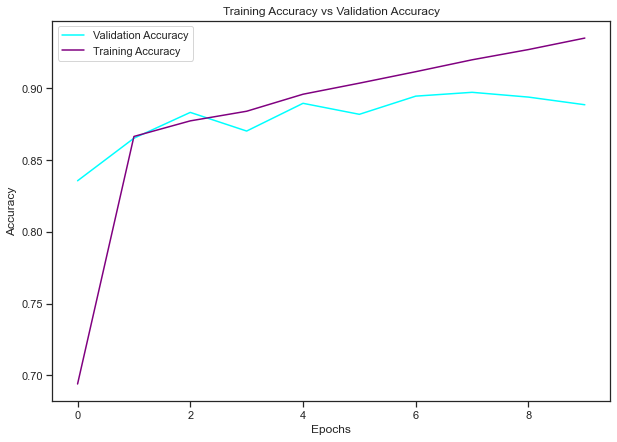

In [43]:
plt.figure(figsize=(10,7))
plt.plot(hist.history['val_loss'], label = 'Validation Loss', color = 'cyan')
plt.plot(hist.history['loss'], label = 'Training Loss', color = 'purple')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizing Testing Accuracy vs Validation Accuracy
plt.figure(figsize=(10,7))
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy', color = 'cyan')
plt.plot(hist.history['accuracy'], label = 'Training Accuracy', color = 'purple')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
from keras.models import load_model
model = load_model('intent_classification_b.h5')

In [22]:
user_input='battery drain after updating and able to use'
padded_text = convert_to_padded(t, user_input)
predictions2 = model.predict(padded_text)
y = np.argmax(predictions2, axis=1)[:1]

2/2 [==============================] - 1s 7ms/step


In [23]:
def infer_intent(user_input):

    assert isinstance(user_input, str)
    user_input = [user_input]
    padded_text = convert_to_padded(t, user_input)
    
    probs = model.predict(padded_text)

    classes = ['battery', 'challenge_robot', 'forgot_password', 'goodbye', 'greeting', 'info',
    'location', 'payment', 'speak_representative', 'update']
    
    
    predictions = dict(zip(classes, probs[0]))
    sorted_predictions = {k: v for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse = True)}
    res = list(sorted_predictions.keys())[0]
    return res

In [24]:
infer_intent("baatery drain after updating")

1/1 [==============================] - 0s 27ms/step


'battery'

In [25]:
infer_intent("Can you please locate a nearest apple store")

1/1 [==============================] - 0s 26ms/step


'location'

In [26]:
infer_intent("When can I expect my refund on my apple iphone")

1/1 [==============================] - 0s 28ms/step


'payment'